In [ ]:
#!/usr/bin/env python3
"""
Wilson's algorithm for unweighted STs.
"""

import numpy as np
import networkx as nx
import sys
sys.path.append('/home/carlo/workspace/networkqit')
import matplotlib.pyplot as plt
import networkqit as nq
import random
import matplotlib

class Wilson:

    def __init__(self, G, q):
        self.G = G
        self.H = nx.DiGraph()
        self.nv = G.number_of_nodes()
        self.q = q
        
        # set edge attribute weight with weight 1
        self.H.add_weighted_edges_from([(u,v,1.0) for u,v in G.edges()])
        self.H.add_weighted_edges_from([(v,u,1.0) for u,v in G.edges()])
        
        # add the magic link from all nodes to n+1 with weight 1/q
        #self.H.add_weighted_edges_from([(self.nv,n, q) for n in G.nodes()])
        self.H.add_weighted_edges_from([(n,self.nv, 1/q) for n in G.nodes()])
        #print(np.asarray([(u,v,w['weight']) for u,v,w in self.H.edges(data=True)]).reshape([60,3]))

    # Choose an edge from v's adjacency list (randomly)
    def random_successor(self, v):
        nei = list(self.H.neighbors(v))
        weight = np.array([ self.H.get_edge_data(v,u)['weight'] for u in nei], dtype=float)
        weight /= weight.sum()
        return np.random.choice(nei, p = weight)
    
    def sample(self):
        intree = [False] * (self.nv+1)
        successor = {}
        # put the additional node
        F = nx.DiGraph()
        self.roots = set()
        root = self.nv
        intree[root] = True
        successor[root] = None

        from random import shuffle
        l = [root] + list(range(self.nv))
        for i in l:
            u = i
            while not intree[u]:
                successor[u] = self.random_successor(u)
                if successor[u] == self.nv: # if the last node of the trajectory is ∆ add it to the roots
                    self.roots.add(u)
                u = successor[u]
            u = i # come back to the node it started from
            # remove self-loops
            while not intree[u]:
                intree[u] = True
                #if u in successor:
                u = successor[u]

        # Creates the random forest
        for i in range(self.nv):
            if i in successor.keys():
                neighbor = successor[i]
                if neighbor is not None:
                    F.add_edge(i,neighbor)
        
        if self.nv in self.roots:
            self.roots.remove(self.nv)
        # remove the magic node, together with all its links
        F.remove_node(F.number_of_nodes() - 1)
        #F.remove_edges_from([(u,self.nv,1.0) for u in F.nodes()])
        # save the leaves
        self.leaves = [n for n in F.nodes() if F.degree(n)==1]
        return F, list(self.roots)
    
    def s(self):
        L = nx.laplacian_matrix(self.G).toarray()
        lambdai = np.linalg.eigvalsh(L)
        return (self.q/(self.q + lambdai)).sum()

def to_networkx(G, T, root_nodes=None):
    T = nx.Graph(T)
    n_trees = nx.number_connected_components(T)
    pos = nx.kamada_kawai_layout(G)
    if root_nodes is not None:
        nx.draw_networkx_nodes(G, pos=pos, nodelist=root_nodes, node_color='r',node_size=25,linew_width=1)
        #nx.draw_networkx_labels(G, pos=pos, labels={i: i for i in range(G.number_of_nodes())})
    nx.draw_networkx_nodes(G, pos=pos, node_color='k', node_size=3, lines_width=0.1)
    nx.draw_networkx_edges(G, pos, edge_style='dashed', alpha=0.1, edge_color='k', edge_width=0.01)

    cmap = matplotlib.cm.get_cmap('viridis')
    for i, t in enumerate(nx.connected_component_subgraphs(T)):
        e = nx.number_of_edges(t)
        #print('|V|=%d |E|=%d' % (t.number_of_nodes(),t.number_of_edges()))
        nx.draw_networkx_edges(t, pos, width=2, edge_cmap=plt.cm.Set2, edge_color=[cmap(float(i)/n_trees)]*e )
    plt.axis('off')
    #plt.show()
    
if __name__=='__main__':
    reps = 10
    G = nx.grid_2d_graph(20, 20, periodic=False)
    #G = nx.path_graph(100)
    G = nx.from_numpy_array(nx.to_numpy_array(G))
    
    #G = nx.planted_partition_graph(4,20,1,0.01)
    beta_range = np.logspace(-3, 3, 50)

    L = nx.laplacian_matrix(G).toarray()

    S = nq.entropy(L=L, beta_range=beta_range)
    Tr = np.log([np.sum(np.exp(-beta*np.linalg.eigvalsh(L))) for beta in beta_range])


    StreeQuenched = np.mean(np.log([[len(Wilson(G,q=q).sample()[1]) for _ in range(reps)] for q in beta_range]),1)
    #StreeAnnealed = np.log(np.mean(([[len(Wilson(G,q=q).sample()[1]) for q in beta_range] for _ in range(reps)]),0))
    plt.semilogx(beta_range, StreeQuenched, color='green', label='<log |R|>')
    #plt.semilogx(beta_range, StreeAnnealed, color='purple', label='log (<|R|>)')
    plt.semilogx(beta_range, np.log([Wilson(G,q=1/q).s() for q in beta_range]), color='magenta', label='stieltjes s(q)')
    plt.semilogx(beta_range, S, color='blue', label='S(\\rho)')
    #plt.semilogx(beta_range, Tr, color='red', label='Z')
    plt.legend()
    # plt.savefig('relation_entropy_random_forest.svg')
    plt.show()
    
    q = 10
    for _ in range(1):
        W = Wilson(G, q=q)
        F,roots = W.sample()
        print(W.s(), np.mean([len(Wilson(G, q=1/q).sample()[1]) for _ in range(reps)]) )

        to_networkx(G, F, roots)
        #plt.savefig('wilson_ring_of_cliques_5_10_beta_1E9.png')
        #print([x for x in F.nodes() if F.degree(x)==1])
        plt.show()

In [ ]:
# Controllare se beta è collegato alla massima distanza delle foglie dal nodo root
if __name__=='__main__':
    reps = 1
    #G = nx.grid_2d_graph(20, 20, periodic=False)
    G = nx.ring_of_cliques(5,10)
    G = nx.path_graph(20)
    #G = nx.path_graph(100)
    #G = nx.from_numpy_array(nx.to_numpy_array(G))
    
    G = nx.complete_graph(10)
    n = G.number_of_nodes()
    beta_range = np.logspace(-3, 1, 100)

    L = nx.laplacian_matrix(G).toarray()

    Z = [np.sum(np.exp(-beta*np.linalg.eigvalsh(L))) for beta in beta_range]

    #R_minus_one_over_beta = [np.linalg.det(np.eye(n)+beta*L) for beta in beta_range]
    logR = np.asarray([np.linalg.slogdet(np.eye(n)+beta*L)[1] for beta in beta_range])
    
    lambda_max = np.linalg.eigvalsh(L).max()
    r = np.array([np.sum([( 1.0/k - 1.0/factorial(k))*(beta**k)*np.trace(np.linalg.matrix_power(L,k)) for k in range(3,10)]) for beta in beta_range])
    S = nq.entropy(L=L,beta_range=beta_range)
    plt.figure(figsize=(18,5))
    plt.semilogx(beta_range, Z)
    #plt.semilogx(beta_range, n - np.log(R_minus_one_over_beta))
    plt.semilogx(beta_range, n - logR)
    plt.ylim([0,n])
    plt.axvline(x=1/lambda_max,ymin=0,ymax=n,color='k',linestyle='dashed') # radius of convergence of beta
    plt.legend(['Z','$n-log(R(-1/\\beta))$'])
    plt.grid(which='both')
    #plt.savefig('ihara.png',bbox_inches='tight')
    plt.title('Partition function vs approximation')
    plt.figure(figsize=(18,5))
    plt.semilogx(beta_range,S,label='S')
    #betaE = [beta*np.trace(np.linalg.inv(beta*I+L))/(n-np.linalg.slogdet(np.eye(n)+beta*L)[1]) for beta in beta_range]
    betaE  = np.asarray([ beta*np.mean([len(Wilson(G,beta).sample()[1]) for _ in range(10)]) for beta in beta_range])/Z
    #np.log(n-logR) + E
    Zapprox = n-logR
    plt.semilogx(beta_range, np.log(Z) - beta_range*betaE, label='Sapprox')
    plt.ylim([0,np.log(len(G))])
    plt.legend()
    plt.grid(which='both')
    plt.title('Spectral entropy vs approximation')
    plt.show()

In [79]:
import networkx as nx
import numpy as np
import scipy
factorial = scipy.math.factorial
import matplotlib.pyplot as plt

#G = nx.erdos_renyi_graph(64,0.8)
G = nx.ring_of_cliques(5,20)
A  = nx.to_numpy_matrix(G)
D = np.asarray(np.diagflat(A.sum(0)))
invD  = np.asarray(np.diagflat(1/A.sum(0)))
n=nx.number_of_nodes(G)
I = np.eye(n)

L = nx.laplacian_matrix(G).toarray()
L = nx.normalized_laplacian_matrix(G).toarray()
#L = invD@L

#H = -L
order=6
rbeta = np.asarray([np.sum([( (-1.0)**k/factorial(k) + (-1.0)**(k+1)/k)*(beta**k)*np.trace(np.linalg.matrix_power(L,k)) for k in range(3,order)]) for beta in beta_range])

beta_range = np.logspace(-3,3,100)
lambdai = np.linalg.eigvalsh(L)
Z = np.asarray([np.sum(np.exp(-beta*lambdai)) for  beta in beta_range])
E = np.asarray([np.sum(lambdai*np.exp(-beta*lambdai)) for beta in beta_range]) / Z
logR = np.asarray([np.linalg.slogdet( np.eye(n) + beta*L )[1] for beta in beta_range])
Eapprox = np.asarray([np.sum(lambdai/(beta*lambdai + 1)) for beta in beta_range])/(n-logR)
Eapprox2 = np.asarray([np.sum(lambdai/(beta*lambdai + 1)) for beta in beta_range])/(n)

(0, 100)

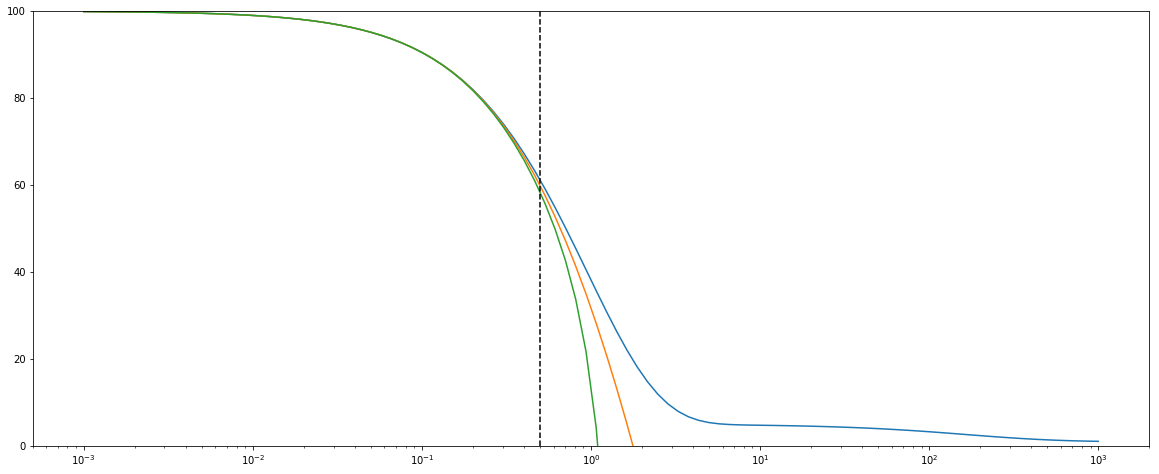

In [80]:
plt.figure(figsize=(20,8))
plt.semilogx(beta_range,Z,label='Z')
plt.semilogx(beta_range,n - logR ,label='n-logR')
plt.semilogx(beta_range,n - logR - rbeta, label='n-logR - rbeta')
plt.axvline(x=0.5,ymin=0,ymax=n,color='black',linestyle='dashed')
plt.ylim([0,n])

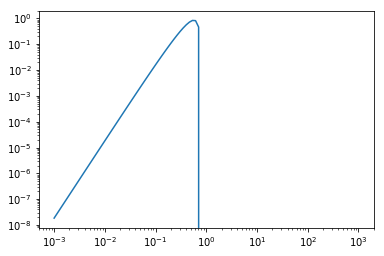

In [72]:
plt.loglog(beta_range,rbeta)

(0, 0.9999476194797436)

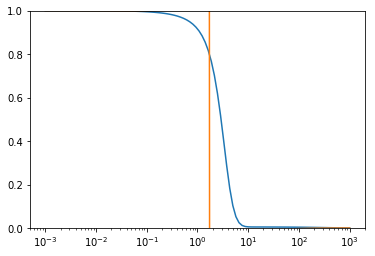

In [70]:
plt.semilogx(beta_range,E)
plt.semilogx(beta_range,Eapprox)
#plt.semilogx(beta_range,Eapprox2)
#plt.xlim([1E-3,1E-1])
plt.ylim([0,E.max()])

/usr/local/lib/python3.6/dist-packages/autograd/tracer.py:48: RuntimeWarning: overflow encountered in exp
  return f_raw(*args, **kwargs)
/usr/local/lib/python3.6/dist-packages/networkqit/infotheory/density2.py:113: RuntimeWarning: invalid value encountered in double_scalars
  entropy[i] = np.log(np.abs(Z)) + b * (lambd * lrho).sum() / Z


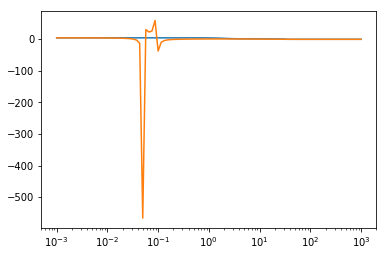

In [194]:
import networkqit as nq
S = nq.entropy(L=H, beta_range=beta_range)
plt.semilogx(beta_range, S)
plt.semilogx(beta_range, np.log(Z) + beta_range*Eapprox)
#plt.axvline(x=1/lambdai.max(),ymin=0,ymax=np.log(n))
#plt.xlim([1E-3,1E-1])

In [ ]:
Z = np.asarray([np.exp(-beta*np.linalg.eigvalsh(L)).sum() for beta in beta_range])
logR = np.asarray([np.linalg.slogdet(np.eye(n) + beta*L)[1] for beta in beta_range])
logRhat = np.asarray([np.linalg.slogdet(np.eye(n-1) + beta*Lhat)[1] for beta in beta_range])
rbeta = np.asarray([np.sum([(1.0/k - 1.0/fact(k))*(beta**k)*np.trace(np.linalg.matrix_power(L,k)) for k in range(3,10)]) for beta in beta_range])
plt.semilogx(beta_range,Z,  label='Z')
plt.semilogx(beta_range, n - logR , label='n-logR')
#plt.semilogx(beta_range, n - logR - rbeta, label='n-logR + r_beta')
lambdaL = np.linalg.eigvalsh(L)
plt.axvline(x=1/lambdaL.max(),ymin=0,ymax=n,linestyle='dashed',color='black')
plt.ylim([0,n])
plt.legend()

In [ ]:
E = 

In [ ]:
plt.semilogx(beta_range,logR-logRhat)

In [ ]:
plt.semilogx(beta_range, n - logR, label='n-logR')

In [ ]:
I = np.eye(len(L))

np.trace(np.linalg.inv(beta*I + L)@L) - np.trace(L@np.linalg.inv(beta*I + L)) 

In [ ]:
l = np.linalg.eigvalsh(L)